In [1]:
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import time

from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox
import geopandas as gpd

def get_point_dataset(location = 'Los Angeles, California, USA', data = gpd.GeoDataFrame()):
    
    print('Getting point datasets..')
    if data.empty:  
        data = ox.geocode_to_gdf(location)        
    west, south, east, north = data.unary_union.bounds
    
    G = ox.graph_from_bbox(north, south, east, west, network_type='all', retain_all=True)
    xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
    x, y = list(zip(*xy))
    # x - list of all x-coordinates
    # y - list of all y-coordinates

    points = gpd.GeoDataFrame(data={'x':x, 'y':y})
    points['geometry'] = points.apply(lambda row: Point((row['x'], row['y'])), axis=1)
    points.crs = data.crs
    points['name'] = 'nodes'
    
    return points

import osmnx as ox
data_1 = ox.geocode_to_gdf('Karnataka, India') # Polygon
data_2 = gpd.read_file("E:\College\Sem 6\capstone\spatial_join_capstone-main\Point_Datasets\India_Hospitals_Point_Dataset\india_hospitals_point.shp") #Point

In [28]:
# don't run all the time
import math
import json
def add_geometry(data, ax, dens, geometry = 'polygon', fc = 'red', ec='k'):
    
    if geometry == 'polygon':
        for i in range(len(data)):
            hex_val = (hex(255-dens[i]))
            hex_val = hex_val[2:]
            if(len(hex_val) < 2):
                hex_val = '0' + hex_val
            fcc = '#00' + hex_val + '00'
            patch = PolygonPatch(data[i], fc=fcc, ec=ec, alpha=0.5, zorder=2)
            ax.add_patch(patch)
            
    elif geometry == 'point':
        ax.scatter(x=data['x'], y=data['y'], s=1, c=fc, linewidth=0, zorder=1)
    
        
def sjoin_with_splitting(data_1, data_2, q_width, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_2 = data_2['geometry'].iloc[0]
    if isinstance(geometry_2, Polygon):
        geometry_2 = MultiPolygon([geometry_2])
          
#     indexing data_2
    sindex_1 = data_1.sindex

    points_within_geometry = pd.DataFrame()

#     Splitting polygon data into squares of width 0.1
    geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry_2, quadrat_width = q_width)
    
    filter_points = 0
    scaled_points_sub_poly = []
    total_points = 0
    
    for sub_poly in geometry_cut:  
        
        # filter phase 
        sub_poly = sub_poly.buffer(1e-14).buffer(0)
        possible_indices = list(sindex_1.intersection(sub_poly.bounds))
        possible_matches = data_1.iloc[possible_indices]
        
        filter_points += len(possible_matches)

        # refinement phase
        precise_matches = possible_matches[possible_matches.intersects(sub_poly)]
        points_within_geometry = points_within_geometry.append(precise_matches)
        scaled_points_sub_poly.append(len(precise_matches))
        total_points += len(precise_matches)
        
    return points_within_geometry

result 
grid_sizes = [0.1, 0.2, 0.5, 0.75, 1]
grid_points = dict()
grid_points_within_geometry = dict()
for sizes in grid_sizes:
    result = sjoin_with_splitting(data_2, data_1, sizes, plot = True)
    grid_points_within_geometry[sizes] = result

with open("E:\College\Sem 6\capstone\Datasets\KA_grid_points_within_geometry.json", "w") as outfile: 
    json.dump(grid_points_within_geometry, outfile)

TypeError: Object of type GeoDataFrame is not JSON serializable

In [ ]:
grid_sizes = [0.1, 0.2, 0.5, 0.75, 1]
grid_points = dict()
grid_points_within_geometry = dict()
for sizes in grid_sizes:
    result = sjoin_with_splitting(data_2, data_1, sizes, plot = True)
    grid_points_within_geometry[sizes] = result

with open("E:\College\Sem 6\capstone\Datasets\KA_grid_points_within_geometry.json", "w") as outfile: 
    json.dump(grid_points_within_geometry, outfile)

In [2]:
import json
with open("E:\College\Sem 6\capstone\Datasets\KA_grid_points.json", "r") as infile:
    grid_points = json.load(infile)
grid_sizes = grid_points.keys()

points = []
for i in grid_points.values():
    points.extend(i)

min_points = min(points)
max_points = max(points)

print(min_points)
print(max_points)

0
913


In [3]:
def add_geometry(data, ax, dens, plt, geometry = 'polygon', fc = 'red', ec='k'):
    
    if geometry == 'polygon':
        for i in range(len(data)):
            hex_val = (hex(255-dens[i]))
            hex_val = hex_val[2:]
            if(len(hex_val) < 2):
                hex_val = '0' + hex_val
            fcc = '#00' + hex_val + 'ff'
            patch = PolygonPatch(data[i], fc=fcc, ec=ec, alpha=0.5, zorder=2)
            ax.add_patch(patch)
    elif geometry == 'point':
        ax.scatter(x=data['x'], y=data['y'], s=1, c=fc, linewidth=0, zorder=1)

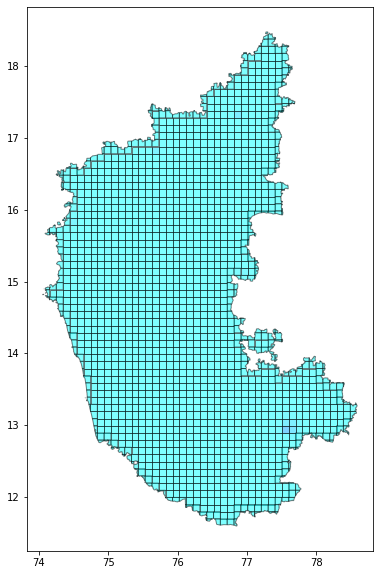

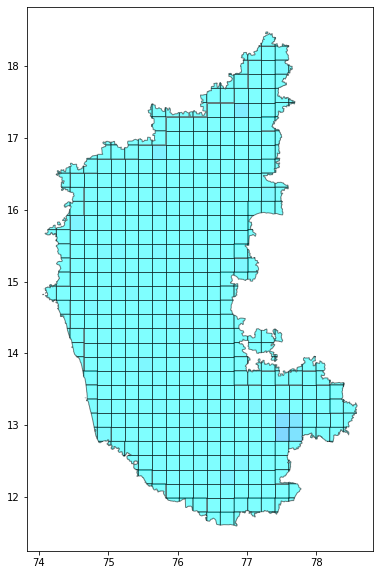

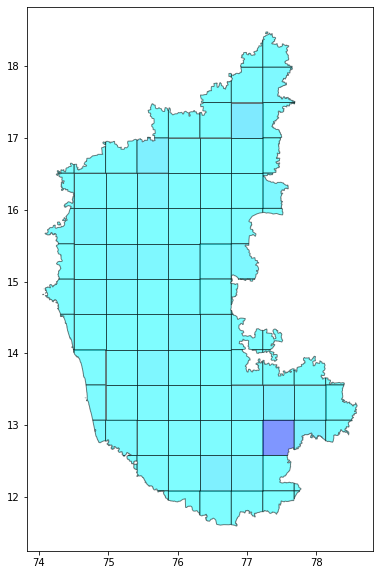

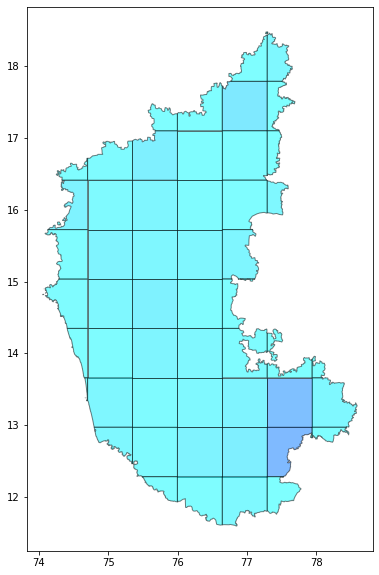

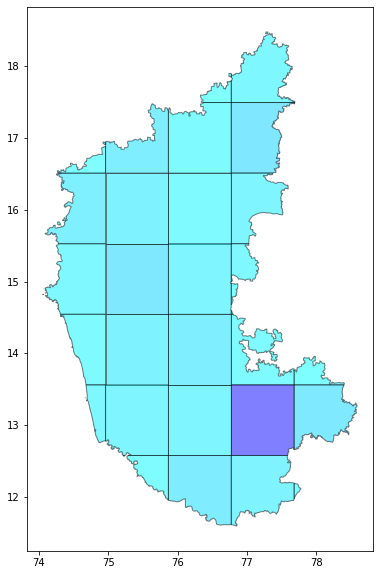

In [4]:
import math
geometry_2 = data_1['geometry'].iloc[0]
if isinstance(geometry_2, Polygon):
    geometry_2 = MultiPolygon([geometry_2])
scaled_grid_points = dict()
# scaling
#grid_sizes = ['1']
for size in grid_sizes:
    scaled_grid_points[size] = [math.floor(((item - min_points) * 255 / (max_points - min_points)) )
                         for item in grid_points[size]] 
    geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry_2, quadrat_width = float(size))
    
    # plotting
    f, ax = plt.subplots(figsize=(10, 10))

    
    data_1.plot(ax = ax, color = 'white')
    
    add_geometry(geometry_cut, ax, scaled_grid_points[size], plt)
    plt.show()


In [5]:
hist_points = dict()
for size in grid_sizes:
    hist_points[size] = [((item - min_points) / (max_points - min_points)) 
                         for item in grid_points[size]] 
print(hist_points)

{'0.1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.0, 0.0, 0.001095290251916758, 0.001095290251916758, 0.001095290251916758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0032858707557502738, 0.001095290251916758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004381161007667032, 0.001095290251916758, 0.0, 0.0, 0.002190580503833516, 0.002190580503833516, 0.0, 0.0, 0.001095290251916758, 0.001095290251916758, 0.001095290251916758, 0.07667031763417305, 0.0, 0.001095290251916758, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.001095290251916758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.001095290251916758, 0.0, 0.001095290251916758, 0.001095290251916758, 0.0, 0.0, 0.001095290251916758, 0.0, 0.0, 0.004381161007667032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.002190580503833516, 0.0, 0.0, 0.0, 0.0, 0.0032858707557502738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001095290251916758, 0.0, 0.0010952

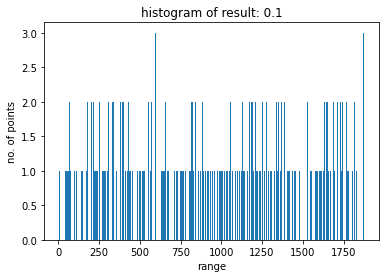

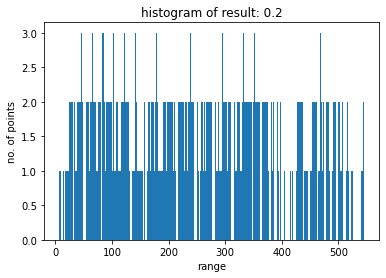

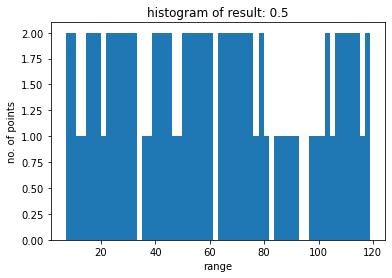

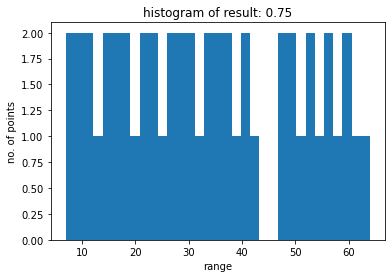

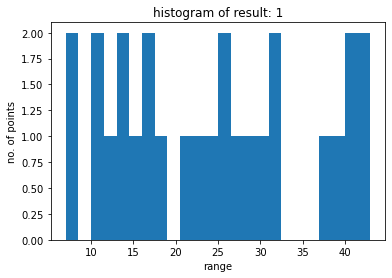

In [24]:
#hist
import numpy as np

for each in grid_sizes:
    fig,ax = plt.subplots(1,1)
    arr = np.array(hist_points[each])
    arr1 = np.argwhere(arr)
    #print(arr1)
    ax.hist(arr1, bins = math.floor(np.average(arr1)))
    ax.set_title("histogram of result: " + str(each))
    #ax.set_xticks([0])
    ax.set_xlabel('range')
    ax.set_ylabel('no. of points')
    plt.show()
    

In [ ]:
print(grid_points)

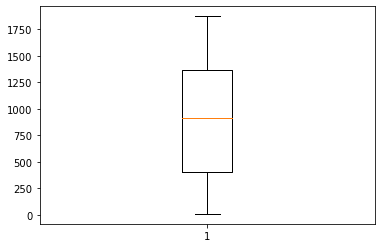

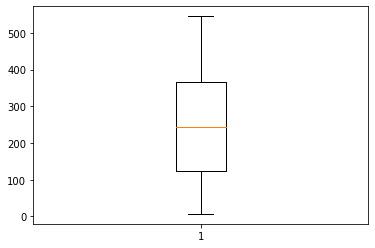

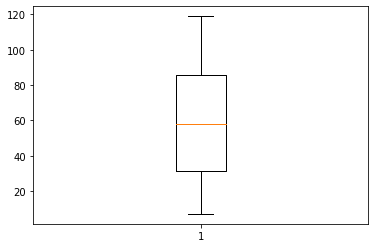

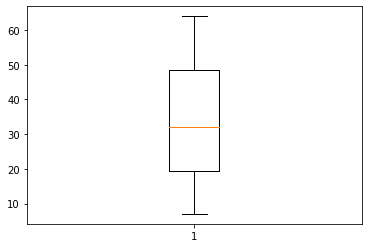

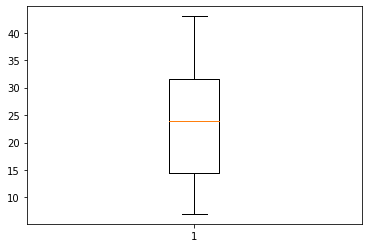

In [25]:
#hist
import numpy as np

for each in grid_sizes:
    fig,ax = plt.subplots(1,1)
    arr = np.array(hist_points[each])
    arr1 = np.argwhere(arr)
    plt.boxplot(arr1)
    plt.show()
    

In [ ]:
tell me tell me
outliers what tell me